<a href="https://colab.research.google.com/github/Juliaroch/Ironhack-final-project-Julia-Roch/blob/master/CNN_INCV3_150420training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib 
import matplotlib.pyplot as plt
import random 
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import auc, roc_curve, roc_auc_score
import keras

Using TensorFlow backend.


In [0]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizers import RMSprop, SGD
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.models import model_from_json, load_model
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#Import the images from 11 artists I need for my training
images_dir = '/content/gdrive/My Drive/Final_project_data/resized_train_test'
data_artists = pd.read_csv('/content/gdrive/My Drive/Final_project_data/data_artists.csv')
artists_dirs = os.listdir(images_dir)
artists_top_name = data_artists['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))


Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Vincent_van_Gogh
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pablo_Picasso
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pierre-Auguste_Renoir
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Francisco_Goya
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Albrecht_Dürer
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Alfred_Sisley
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Marc_Chagall
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Edgar_Degas
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Rembrandt
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Titian
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Paul_Gauguin


In [5]:
#See if images have been imported correctly 
#n = 5
#fig, axes = plt.subplots(1, n, figsize=(20,10))

'''for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()'''

'for i in range(n):\n    random_artist = random.choice(artists_top_name)\n    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))\n    random_image_file = os.path.join(images_dir, random_artist, random_image)\n    image = plt.imread(random_image_file)\n    axes[i].imshow(image)\n    axes[i].set_title("Artist: " + random_artist.replace(\'_\', \' \'))\n    axes[i].axis(\'off\')\n\nplt.show()'

In [6]:
#Train_test_split
batch_size = 16
train_input_shape = (128, 128, 3)
n_classes = artists_top_name.shape[0]

train_datagen=ImageDataGenerator(validation_split=0.1,rescale=1./255.,horizontal_flip=True,vertical_flip=True)
                                 
train_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="training",shuffle=True,classes=artists_top_name.tolist())
                                                   
valid_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="validation",shuffle=True,classes=artists_top_name.tolist())

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2384 images belonging to 11 classes.
Found 262 images belonging to 11 classes.
Total number of batches = 149 and 16


In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=train_input_shape)

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have n_classes classes
output = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

optimizer = tf.keras.optimizers.RMSprop(lr=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
n_epoch = 6

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')

In [11]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr], use_multiprocessing=True, workers=16)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/6
149/149 [==============================] - 12s 83ms/step - loss: 1.3548 - accuracy: 0.8557 - val_loss: 3.5018 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/6
149/149 [==============================] - 12s 81ms/step - loss: 0.5247 - accuracy: 0.9027 - val_loss: 3.1336 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/6
149/149 [==============================] - 12s 81ms/step - loss: 0.4260 - accuracy: 0.9073 - val_loss: 3.2041 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/6
149/149 [==============================] - 12s 83ms/step - loss: 0.4259 - accuracy: 0.8993 - val_loss: 1.8193 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/6
149/149 [==============================] - 12s 84ms/step - loss: 0.3594 - accuracy: 0.9165 - val_loss: 2.0313 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/6
149/149 [==============================] - 13s 85ms/step - loss: 0.3025 - accuracy: 0.9237 - val_loss: 3.2773 - val_accuracy: 0.4414 -

In [12]:
for layer in model.layers[:249]:
   layer.trainable = False

for layer in model.layers[249:]:
   layer.trainable = True

#for layer in model.layers[:172]:
  # layer.trainable = False

#for layer in model.layers[172:]:
 #  layer.trainable = True

tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(optimizer='SGD', loss='categorical_crossentropy',metrics=['accuracy'])

n_epoch = 28
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr, early_stop], use_multiprocessing=True, workers=16)

Epoch 1/28
149/149 [==============================] - 17s 116ms/step - loss: 0.2092 - accuracy: 0.9534 - val_loss: 2.3345 - val_accuracy: 0.2578 - lr: 0.0100
Epoch 2/28
149/149 [==============================] - 16s 108ms/step - loss: 0.1489 - accuracy: 0.9664 - val_loss: 2.0583 - val_accuracy: 0.3164 - lr: 0.0100
Epoch 3/28
149/149 [==============================] - 16s 110ms/step - loss: 0.1362 - accuracy: 0.9643 - val_loss: 1.4828 - val_accuracy: 0.6055 - lr: 0.0100
Epoch 4/28
149/149 [==============================] - 17s 115ms/step - loss: 0.1148 - accuracy: 0.9685 - val_loss: 2.1896 - val_accuracy: 0.3242 - lr: 0.0100
Epoch 5/28
149/149 [==============================] - 16s 109ms/step - loss: 0.1157 - accuracy: 0.9698 - val_loss: 1.8057 - val_accuracy: 0.4414 - lr: 0.0100
Epoch 6/28
149/149 [==============================] - 21s 141ms/step - loss: 0.0963 - accuracy: 0.9723 - val_loss: 1.4212 - val_accuracy: 0.6211 - lr: 0.0100
Epoch 7/28
149/149 [==============================] 

In [0]:
#score = model.evaluate_generator(train_generator, verbose=1)
#print("Prediction accuracy on train data =", score[1])

In [0]:
#score = model.evaluate_generator(valid_generator, verbose=1)
#print("Prediction accuracy on CV data =", score[1])

In [0]:
# serialize weights to HDF5 & model to json
##model.save_weights('/content/gdrive/My Drive/Final_project_data/model_weights140420v2.h5')
#print("Saved model to disk")
#model_json = model.to_json()
# Save the model architecture
#with open('/content/gdrive/My Drive/Final_project_data/model_architecture140420v2.json', 'w') as f:
 #   f.write(model.to_json())
#print("Saved model to disk2")    

In [0]:
model.save('/content/gdrive/My Drive/Final_project_data/my_model150420v3.h5')

In [0]:
#new_model_2 = load_model('/content/gdrive/My Drive/Final_project_data/my_model140420v2.h5')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


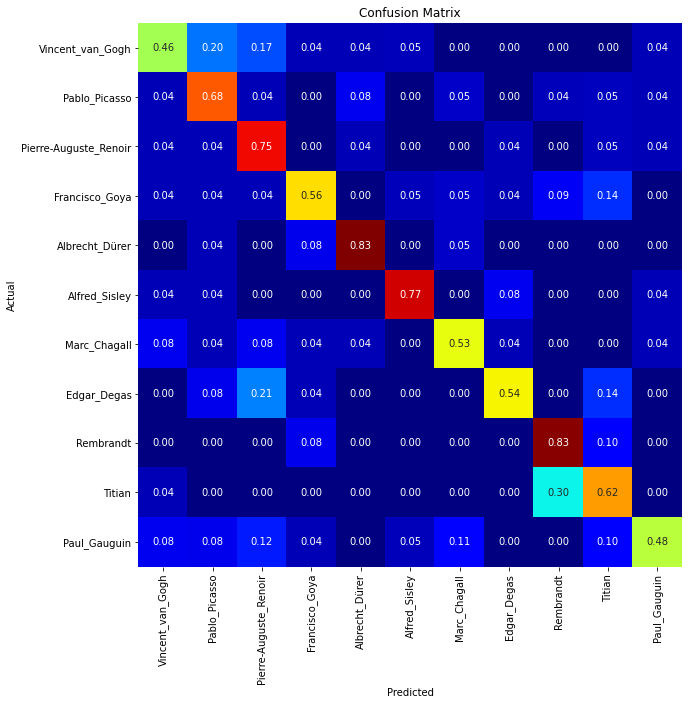

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.55      0.46      0.50        24
        Pablo_Picasso       0.55      0.68      0.61        25
Pierre-Auguste_Renoir       0.53      0.75      0.62        24
       Francisco_Goya       0.64      0.56      0.60        25
       Albrecht_Dürer       0.80      0.83      0.82        24
        Alfred_Sisley       0.85      0.77      0.81        22
         Marc_Chagall       0.67      0.53      0.59        19
          Edgar_Degas       0.72      0.54      0.62        24
            Rembrandt       0.66      0.83      0.73        23
               Titian       0.52      0.62      0.57        21
         Paul_Gauguin       0.71      0.48      0.57        25

             accuracy                           0.64       256
            macro avg       0.65      0.64      0.64       256
         weighted avg       0.65      0.64      0.64       256



In [18]:
 # Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

    return y_pred, y_true

y_pred, y_true = showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

In [19]:
y_pred
y_true

array([ 2,  1,  8,  3,  4,  4,  3,  0,  5,  8,  2,  3,  1,  8,  9,  8,  0,
       10,  5,  1,  7, 10,  8,  2,  6,  1,  1,  5,  0,  3,  3,  0,  2,  8,
        5, 10, 10, 10,  3,  9,  3,  1,  5,  2,  7,  7, 10,  8,  6,  5,  3,
        9,  4,  1,  8,  1,  8,  4, 10,  0, 10, 10,  5,  4,  7,  9,  1,  7,
        2,  4,  6,  3,  9,  1,  3,  4,  6, 10,  3,  2,  2,  7,  0,  1,  6,
        9,  9,  9,  8,  5,  6,  8,  6,  7,  1,  9,  2,  7,  2,  3,  6,  5,
        2,  3,  7,  5,  4,  6,  0,  0,  7,  3,  3,  9, 10, 10,  4, 10,  9,
        6,  0, 10,  1,  1,  9,  2,  1, 10,  2,  6, 10,  2,  7,  0,  8,  4,
       10,  2,  9, 10,  2,  7,  2,  0,  7,  3,  1,  8,  0,  6,  4,  4,  5,
        5,  3,  4,  8,  3,  9,  8,  8,  3,  6,  9,  0,  5,  3,  6,  4,  6,
        9,  7,  7,  7,  6, 10,  0, 10,  8,  5,  0,  1,  0,  9,  1,  7,  4,
        1,  5,  4,  9,  4,  1,  2,  7,  6, 10,  8,  4,  8,  0,  7,  1,  0,
        7,  3,  0,  9,  8,  4,  2,  0,  5,  4,  0,  0,  7,  2,  3,  5, 10,
       10,  3,  9,  1,  2

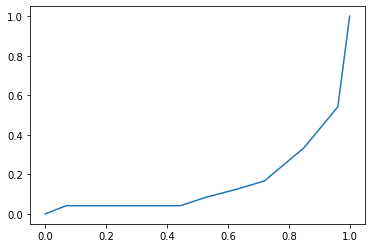

AUC: 0.15741738505747127


In [20]:
#Calculating roc and auc curves
y_true = y_true # true labels
y_probas = y_pred # predicted results
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

IndexError: ignored

In [0]:
# serialize model to JSON
#model_json = model.to_json()
#with open("/content/gdrive/My Drive/Final_project_data/JI3-FC-34TE-130420v3.json", "w") as json_file:
 #   json_file.write(json.dumps(json.loads(model_json), indent=4))
#json_config = model.to_json("/content/gdrive/My Drive/Final_project_data/JI3-FC-34TE-130420v3.json")


In [0]:
# Creates a HDF5 file 'my_model.h5'
model.save('/content/gdrive/My Drive/Final_project_data/my_model140420v22.h5')

# Deletes the existing model
del model 
#model.save('/content/gdrive/My Drive/Final_project_data/MI3-FC-34TE-130420v3.h5') 

In [0]:
#Calculating roc and auc scores
y_pred_keras = y_pred
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras, pos_label=0)

auc_keras = auc(fpr_keras, tpr_keras)
print(fpr_keras, tpr_keras, thresholds_keras)
print(auc_keras)

In [0]:

roc_auc_score(y_true, y_pred, multi_class='ovo')